In [44]:
import os

interface_dir = os.environ["DATA"] + "webinterfaces/exp01/"

tasks_dir = os.path.join(interface_dir, "res", "tasks")
results_dir = os.path.join(interface_dir, "results")
protocols_dir = os.path.join(interface_dir, "protocols")
prolific_matching_dir = os.path.join(interface_dir, "prolific")

protocol_paths_d = {
    "H": os.path.join(protocols_dir, "H_0.json"),
    "H+AI": os.path.join(protocols_dir, "AI_0.json"),
    "H+AI+CF": os.path.join(protocols_dir, "XAI_CF_0.json"),
    "H+AI+SHAP": os.path.join(protocols_dir, "XAI_SHAP_0.json"),
}

COMPREHENSION_THRESHOLD = 0.8

COMPREHENSION_TASKS = ["xeasy1_find_pattern_rot"]
TRAINING_TASKS = ["easy3_find_pattern_rot"]
EASY_TASKS = ["med1_find_pattern_rot", "med3_find_pattern_rot"]
DIFFICULT_TASKS = ["hard1_find_pattern_rot", "hard3_find_pattern_rot"]

MILD_PRESSURE_TASKS = ["med1_find_pattern_rot", "hard1_find_pattern_rot"]
STRONG_PRESSURE_TASKS = ["med3_find_pattern_rot", "hard3_find_pattern_rot"]

TASK_PROTOCOL_KEYS = {
    "med1_find_pattern_rot": "mainexp_easy1_patrot_task",
    "med3_find_pattern_rot": "mainexp_easy2_patrot_task",

    "hard1_find_pattern_rot": "mainexp_hard1_patrot_task",
    "hard3_find_pattern_rot": "mainexp_hard2_patrot_task",

    "xeasy1_find_pattern_rot": "intro_comprehension_task",
    "easy3_find_pattern_rot": "intro_training_1_task"
}


In [45]:
import sys

sys.path.append("/home/jleguy/Documents/postdoc/git_repos/WebXAII/")

In [46]:
import json
import csv
import numpy as np


def load_json(path):
    with open(path) as json_file:
        return json.load(json_file)


def load_task_csv_file(path):
    y_true, y_pred = [], []
    with open(path) as csv_data:
        reader = csv.DictReader(csv_data)
        for row in reader:
            y_true.append(int(row["target"]))
            y_pred.append(int(row["pred"]))

    return np.array(y_true), np.array(y_pred)


In [47]:
import json

def data_matching(protocols_paths_d, prolific_matching_files):

    results_filenames_d = {k: [] for k in protocol_paths_d.keys()}

    for prolific_matching_file in prolific_matching_files:

        with open(prolific_matching_file) as json_data:
            d = json.load(json_data)

            for prolific_id, prot_dict in d.items():
                condition_split = prot_dict["protocol"].split("_")
                filename = prolific_id + ".json"

                if condition_split[0] == "H":
                    results_filenames_d["H"].append(filename)
                elif condition_split[0] == "AI":
                    results_filenames_d["H+AI"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "SHAP":
                    results_filenames_d["H+AI+SHAP"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "CF":
                    results_filenames_d["H+AI+CF"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "LLM":
                    results_filenames_d["LLM"].append(filename)

    return results_filenames_d


In [48]:
from pywebxaii.resretrieval import extract_p_questionnaire_results, get_protocol_entry_from_key

def extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = {"raw": {}, "values": {}, "times": {}}

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            data_issue = False
            if not curr_res_d["is_completed"]:
                data_issue = True

            # Iterating over all questionnaires keys
            for quest_key in quest_keys:

                curr_protocol_d = load_json(protocol_paths_d[group_key])
                try:
                    get_protocol_entry_from_key(curr_protocol_d, quest_key)
                    answers_raw, answers_values, quest_times = extract_p_questionnaire_results(curr_res_d,
                                                                                               quest_key,
                                                                                               protocol_d=curr_protocol_d)
                except KeyError:
                    data_issue = True

                if quest_key not in output_res_d[group_key]["raw"]:
                    output_res_d[group_key]["raw"][quest_key] = []
                    output_res_d[group_key]["values"][quest_key] = []
                    output_res_d[group_key]["times"][quest_key] = []

                if data_issue:
                    output_res_d[group_key]["raw"][quest_key].append(None)
                    output_res_d[group_key]["values"][quest_key].append(None)
                    output_res_d[group_key]["times"][quest_key].append(None)
                else:
                    output_res_d[group_key]["raw"][quest_key].append(answers_raw)
                    output_res_d[group_key]["values"][quest_key].append(answers_values)
                    output_res_d[group_key]["times"][quest_key].append(quest_times)

    return output_res_d

In [49]:
from pywebxaii.resretrieval import extract_p_task_results


def compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, tasks_names, task_protocol_keys):
    output_res_scores_d = {}
    output_res_reliance_d = {}
    output_res_overreliance_d = {}
    output_res_underreliance_d = {}
    output_res_appropriate_reliance_d = {}
    output_res_answer_times_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_scores_d[group_key] = []
        output_res_reliance_d[group_key] = []
        output_res_overreliance_d[group_key] = []
        output_res_underreliance_d[group_key] = []
        output_res_appropriate_reliance_d[group_key] = []
        output_res_answer_times_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue

            nb_questions = 0
            nb_quest_wrong_predictions = 0
            nb_quest_right_predictions = 0
            nb_correct = 0
            nb_reliance = 0
            nb_overreliance = 0
            nb_underreliance = 0
            nb_appropriate = 0
            answer_times = []
            early_break = False

            # Iterating over all tasks
            for task_idx, task_name in enumerate(tasks_names):

                task_true, ai_pred = load_task_csv_file(os.path.join(tasks_dir, task_name + "_content.csv"))

                answers_idx_vect, answers_text_vect, time_vect, _, _ = \
                    extract_p_task_results(curr_res_d,
                                           task_protocol_keys[tasks_names[task_idx]],
                                           protocol_d=load_json(protocol_paths_d[group_key]))

                nb_questions += len(answers_idx_vect)
                nb_quest_wrong_predictions += np.sum(task_true != ai_pred)
                nb_quest_right_predictions += np.sum(task_true == ai_pred)

                try:
                    nb_correct += np.sum(answers_idx_vect == np.logical_not(task_true))
                    nb_reliance += np.sum(answers_idx_vect == np.logical_not(ai_pred))
                    nb_overreliance += np.sum(np.logical_and(
                        answers_idx_vect == np.logical_not(ai_pred),
                        ai_pred != task_true
                    ))
                    nb_underreliance += np.sum(np.logical_and(
                        answers_idx_vect != np.logical_not(ai_pred),
                        ai_pred == task_true
                    ))
                    answer_times.extend((np.array(time_vect)/1000).tolist())
                    #
                    # if np.isnan(np.sum(answers_idx_vect)):
                    #     print(f"answers {answers_idx_vect}")
                    #     print(f"true {np.logical_not(task_true)}")
                    #     print(f"ai pred {np.logical_not(ai_pred)}")
                    #     print(f"correct extracted {np.sum(answers_idx_vect == np.logical_not(task_true))}")
                    #     print(f"reliance extracted {np.sum(answers_idx_vect == np.logical_not(ai_pred))}")

                # Happens if the results file is not complete
                except ValueError:
                    print("ValueError exception")
                    output_res_scores_d[group_key].append(None)
                    output_res_reliance_d[group_key].append(None)
                    output_res_overreliance_d[group_key].append(None)
                    output_res_underreliance_d[group_key].append(None)
                    output_res_answer_times_d[group_key].append(None)
                    early_break = True
                    break

            if not early_break:
                output_res_scores_d[group_key].append(nb_correct / nb_questions)
                output_res_reliance_d[group_key].append(nb_reliance / nb_questions)
                output_res_overreliance_d[group_key].append(nb_overreliance / nb_quest_wrong_predictions)
                output_res_underreliance_d[group_key].append(nb_underreliance / nb_quest_right_predictions)
                output_res_answer_times_d[group_key].extend(answer_times)

    return output_res_scores_d, output_res_reliance_d, output_res_overreliance_d, output_res_underreliance_d, output_res_answer_times_d


In [50]:
results_filenames_d = data_matching(protocol_paths_d, [os.path.join(prolific_matching_dir, "1prolific.json"),
                                                       os.path.join(prolific_matching_dir, "2prolific.json")])

In [51]:
results_filenames_d

{'H': ['5c5cad3e4ee81200018eafe2.json',
  '680bed1f9ba8a836a72dfda6.json',
  '5f6674b8ff4a11134f4ff972.json',
  '5c80e889a1d4b900114f2be3.json',
  '595cd88562431800019d691a.json',
  '5bb7abf3c190e20001e5c2c8.json',
  '5c158ec0c6b01c0001bcfa72.json',
  '5efcb50255a06b097b8d5d29.json',
  '6783ebc2e89b75d66d952f41.json',
  '681b781064a5701a5ceee3bc.json'],
 'H+AI': ['577a0a7aadbc7500015d2479.json',
  '6412fe162863d9871d64ac53.json',
  '676055469b245b53e81358d0.json',
  '63117718025bf2d9641bbb33.json',
  '5bfe0d18e373c90001b57c71.json',
  '6717d0f52cc5e0a7f13b596a.json',
  '62e3f7b224ec70641fd86b7b.json',
  '58cd0bc2a47dbb000171dc8b.json',
  '5a9fa90f873cda00010d29d8.json',
  '5d8e154af2858200171fdb95.json',
  '669177c66d14fd83c2a18125.json',
  '5eaee1fd7af2520426d8b9bd.json'],
 'H+AI+CF': ['5be9b18df5c1060001085048.json',
  '5caa11e5a15c9800161ad16d.json',
  '60f5d1dfd8ff71196982160b.json',
  '5755c957eb80c4000741a9ce.json',
  '5c2f6d25e38ccd0001caab19.json',
  '66cc6eb364154a51d4d44eb1.j

In [52]:
for k, v in results_filenames_d.items():
    print(f"{k}: {len(v)}")

H: 10
H+AI: 12
H+AI+CF: 12
H+AI+SHAP: 11


In [53]:
def filter_not_completed(results_filenames_d):
    filtered_results_filenames_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        filtered_results_filenames_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            filtered_results_filenames_d[group_key].append(filename)
    return filtered_results_filenames_d

In [54]:
results_filenames_d = filter_not_completed(results_filenames_d)

In [55]:
for k, v in results_filenames_d.items():
    print(f"{k}: {len(v)}")

H: 10
H+AI: 10
H+AI+CF: 11
H+AI+SHAP: 9


In [56]:
def filter_on_attention_tests(results_filenames_d):
    res = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1", "attentioncheck_2"])
    filtered_results_filenames_d = {}

    for k, v in res.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):

            if v["raw"]["attentioncheck_1"][i] is None:
                passes1 = False
            else:
                passes1 = v["raw"]["attentioncheck_1"][i][0] == 2 and v["raw"]["attentioncheck_1"][i][1] == 0


            if v["raw"]["attentioncheck_2"][i] is None:
                passes2 = False
            else:
                passes2 = v["raw"]["attentioncheck_2"][i][0] == 6 and v["raw"]["attentioncheck_2"][i][1] == 0

            if passes1 and passes2:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])

    return filtered_results_filenames_d

In [57]:
results_filenames_d = filter_on_attention_tests(results_filenames_d)

In [58]:
for k, v in results_filenames_d.items():
    print(f"{k}: {len(v)}")

H: 0
H+AI: 0
H+AI+CF: 11
H+AI+SHAP: 9


In [59]:
def filter_comprehension_score(results_filenames_d):
    comprehension_score_d, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)
    filtered_results_filenames_d = {}

    for k, v in comprehension_score_d.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if comprehension_score_d[k][i] >= COMPREHENSION_THRESHOLD:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])

    return filtered_results_filenames_d


In [60]:
results_filenames_d = filter_comprehension_score(results_filenames_d)

In [61]:
for k, v in results_filenames_d.items():
    print(f"{k}: {len(v)}")

H: 0
H+AI: 0
H+AI+CF: 8
H+AI+SHAP: 8


In [41]:
all_scores, all_reliance, all_overreliance, all_underreliance, all_times = compute_scores(results_dir, results_filenames_d, protocol_paths_d,
                                                            tasks_dir,
                                                            EASY_TASKS + DIFFICULT_TASKS, TASK_PROTOCOL_KEYS)

all_scores_easy, all_reliance_easy, all_overreliance_easy, all_underreliance_easy, all_times_easy = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           EASY_TASKS, TASK_PROTOCOL_KEYS)

all_scores_difficult, all_reliance_difficult, all_overreliance_difficult, all_underreliance_difficult, all_times_difficult = compute_scores(results_dir,
                                                                                          results_filenames_d,
                                                                                          protocol_paths_d,
                                                                                          tasks_dir, DIFFICULT_TASKS,
                                                                                          TASK_PROTOCOL_KEYS)

all_scores_mild, all_reliance_mild, all_overreliance_mild, all_underreliance_mild, all_times_mild = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           MILD_PRESSURE_TASKS,
                                                                           TASK_PROTOCOL_KEYS)

all_scores_strong, all_reliance_strong, all_overreliance_strong, all_underreliance_strong, all_times_strong = compute_scores(results_dir, results_filenames_d,
                                                                                 protocol_paths_d, tasks_dir,
                                                                                 STRONG_PRESSURE_TASKS,
                                                                                 TASK_PROTOCOL_KEYS)

comprehension_score, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)

# all_scores_findpatterns, all_reliance_findpatterns, all_overreliance_findpatterns = compute_scores(results_dir,
#                                                                                                    results_filenames_d,
#                                                                                                    protocol_paths_d,
#                                                                                                    tasks_dir,
#                                                                                                    FIND_PATTERNS_TASKS,
#                                                                                                    TASK_PROTOCOL_KEYS)
# all_scores_countsym, all_reliance_countsym, all_overreliance_countsym = compute_scores(results_dir, results_filenames_d,
#                                                                                        protocol_paths_d,
#                                                                                        tasks_dir, COUNT_SYMBOLS_TASKS,
#                                                                                        TASK_PROTOCOL_KEYS)

In [42]:
all_scores

{'H': [0.6538461538461539,
  0.6538461538461539,
  0.6346153846153846,
  0.6730769230769231,
  0.6923076923076923,
  0.6346153846153846,
  0.9423076923076923,
  0.4807692307692308,
  0.5,
  0.6346153846153846],
 'H+AI': [0.75,
  0.9423076923076923,
  0.7884615384615384,
  0.7692307692307693,
  0.8076923076923077,
  0.7115384615384616,
  0.7884615384615384,
  0.7884615384615384,
  0.6730769230769231,
  0.9038461538461539],
 'H+AI+CF': [0.7884615384615384,
  0.7692307692307693,
  0.7884615384615384,
  0.8653846153846154,
  0.7115384615384616,
  0.7884615384615384,
  0.6346153846153846,
  0.5769230769230769,
  0.6730769230769231,
  0.8461538461538461,
  0.8461538461538461],
 'H+AI+SHAP': [0.7692307692307693,
  0.8653846153846154,
  0.8461538461538461,
  0.8076923076923077,
  0.8653846153846154,
  0.6153846153846154,
  0.8653846153846154,
  0.7884615384615384,
  0.8461538461538461]}

In [43]:
all_scores_easy

{'H': [0.6538461538461539,
  0.6923076923076923,
  0.6923076923076923,
  0.6538461538461539,
  0.6923076923076923,
  0.8461538461538461,
  1.0,
  0.5,
  0.5384615384615384,
  0.7307692307692307],
 'H+AI': [0.7692307692307693,
  0.9230769230769231,
  0.7692307692307693,
  0.7692307692307693,
  0.8076923076923077,
  0.6923076923076923,
  0.7692307692307693,
  0.8076923076923077,
  0.6538461538461539,
  0.8846153846153846],
 'H+AI+CF': [0.6923076923076923,
  0.7307692307692307,
  0.8461538461538461,
  0.8461538461538461,
  0.6153846153846154,
  0.7692307692307693,
  0.6538461538461539,
  0.5769230769230769,
  0.7307692307692307,
  0.8461538461538461,
  0.8461538461538461],
 'H+AI+SHAP': [0.7692307692307693,
  0.8846153846153846,
  0.8461538461538461,
  0.7307692307692307,
  0.8846153846153846,
  0.6538461538461539,
  0.8846153846153846,
  0.8846153846153846,
  0.8846153846153846]}

In [44]:
all_scores_difficult

{'H': [0.6538461538461539,
  0.6153846153846154,
  0.5769230769230769,
  0.6923076923076923,
  0.6923076923076923,
  0.4230769230769231,
  0.8846153846153846,
  0.46153846153846156,
  0.46153846153846156,
  0.5384615384615384],
 'H+AI': [0.7307692307692307,
  0.9615384615384616,
  0.8076923076923077,
  0.7692307692307693,
  0.8076923076923077,
  0.7307692307692307,
  0.8076923076923077,
  0.7692307692307693,
  0.6923076923076923,
  0.9230769230769231],
 'H+AI+CF': [0.8846153846153846,
  0.8076923076923077,
  0.7307692307692307,
  0.8846153846153846,
  0.8076923076923077,
  0.8076923076923077,
  0.6153846153846154,
  0.5769230769230769,
  0.6153846153846154,
  0.8461538461538461,
  0.8461538461538461],
 'H+AI+SHAP': [0.7692307692307693,
  0.8461538461538461,
  0.8461538461538461,
  0.8846153846153846,
  0.8461538461538461,
  0.5769230769230769,
  0.8461538461538461,
  0.6923076923076923,
  0.8076923076923077]}

In [45]:
comprehension_score

{'H': [0.8333333333333334,
  0.8333333333333334,
  1.0,
  1.0,
  0.8333333333333334,
  1.0,
  1.0,
  1.0,
  0.8333333333333334,
  0.8333333333333334],
 'H+AI': [0.8333333333333334,
  1.0,
  1.0,
  0.8333333333333334,
  1.0,
  0.8333333333333334,
  1.0,
  1.0,
  1.0,
  1.0],
 'H+AI+CF': [0.6666666666666666,
  1.0,
  1.0,
  1.0,
  0.5,
  0.8333333333333334,
  0.5,
  1.0,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334],
 'H+AI+SHAP': [1.0,
  0.8333333333333334,
  1.0,
  0.8333333333333334,
  1.0,
  1.0,
  1.0,
  1.0,
  0.5]}

In [46]:
data_scores_difficulty = {
    "easy tasks": all_scores_easy,
    "difficult tasks": all_scores_difficult,
}

data_scores_pressure = {
    "mild pressure tasks": all_scores_mild,
    "strong pressure tasks": all_scores_strong,
}

In [47]:
all_scores_training, all_reliance_training, all_overreliance_training, all_underreliance_training, _ = compute_scores(results_dir, results_filenames_d,
                                                                                                                   protocol_paths_d, tasks_dir,
                                                                                                                    TRAINING_TASKS, TASK_PROTOCOL_KEYS)

In [48]:
all_scores_training

{'H': [1.0,
  0.6666666666666666,
  1.0,
  0.8333333333333334,
  0.6666666666666666,
  1.0,
  0.8333333333333334,
  1.0,
  0.6666666666666666,
  0.8333333333333334],
 'H+AI': [0.8333333333333334,
  1.0,
  0.8333333333333334,
  0.8333333333333334,
  1.0,
  0.8333333333333334,
  0.8333333333333334,
  1.0,
  0.8333333333333334,
  1.0],
 'H+AI+CF': [0.8333333333333334,
  1.0,
  0.8333333333333334,
  1.0,
  0.6666666666666666,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334],
 'H+AI+SHAP': [1.0,
  1.0,
  0.8333333333333334,
  0.3333333333333333,
  0.6666666666666666,
  1.0,
  0.8333333333333334,
  1.0,
  1.0]}

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_boxplot(data, group_name, title="Group Box Plot", y_lim=None, y_line=None, figsize=(7, 4)):
    """
    Seaborn version of grouped boxplots.
    Data format:
        {"group1": [...], "group2": [...], ...}
    """

    # Convert dict into a DataFrame
    rows = []
    for group, values in data.items():
        for v in values:
            rows.append({group_name: group, "value": v})
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value"
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def scatter_groups_nested(data, outer_name, inner_name, title="Group Scatter Plot", y_lim=None, y_line=None, figsize=(7,4)):
    """
    Seaborn version of scatter_groups_nested.
    Data format:
        {
            "outerGroup1": {"innerA": [...], "innerB": [...], ...},
            "outerGroup2": {"innerA": [...], "innerB": [...], ...},
        }
    Outer group = color
    Inner group = x-axis category
    """

    # Flatten into DataFrame
    rows = []
    for outer, inner_dict in data.items():
        for inner, values in inner_dict.items():
            for v in values:
                rows.append({
                    outer_name: outer,
                    inner_name: inner,
                    "value": v
                })
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.scatterplot(
        data=df,
        x=inner_name,
        y="value",
        hue=outer_name,
        style=outer_name,  # keeps outer groups visually separated
        s=50
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_boxplot_two(
        data1,
        data2,
        group_name,
        dataset_name="Dataset",
        labels=("A", "B"),
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(7, 4),
):
    """
    Seaborn version of grouped side-by-side boxplots.

    Data format:
        data1 = {"group1": [...], "group2": [...], ...}
        data2 = {"group1": [...], "group2": [...], ...}
    """

    rows = []

    for group, values in data1.items():
        for v in values:
            rows.append({group_name: group, "value": v, dataset_name: labels[0]})

    for group, values in data2.items():
        for v in values:
            rows.append({group_name: group, "value": v, dataset_name: labels[1]})

    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_boxplot_nested(
        data,
        group_name,
        dataset_name="Dataset",
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(7, 4),
):
    rows = []

    for dataset, groups in data.items():
        for group, values in groups.items():
            for v in values:
                rows.append({
                    group_name: group,
                    "value": v,
                    dataset_name: dataset
                })

    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()




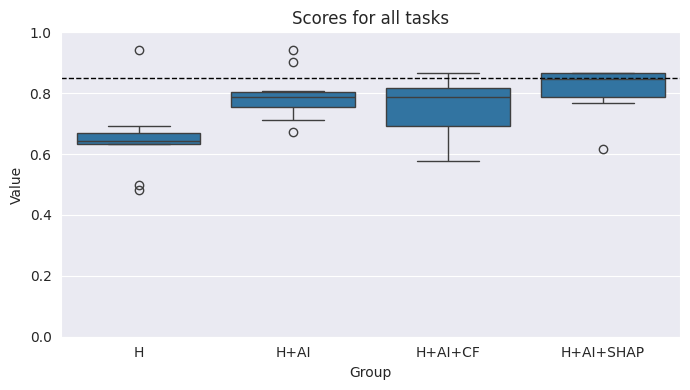

In [50]:
plot_boxplot(all_scores, group_name="Group", title="Scores for all tasks", y_lim=(0, 1), y_line=0.85)


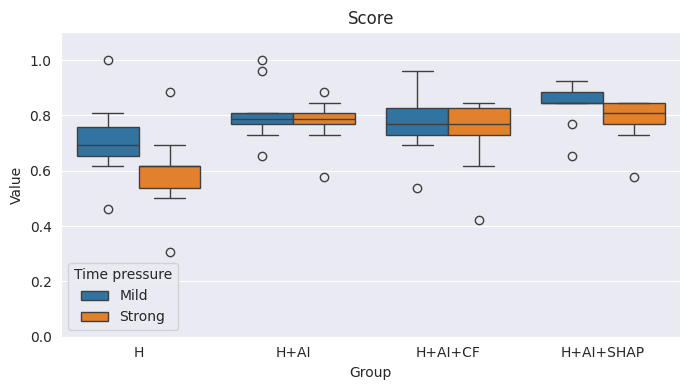

In [51]:
plot_boxplot_two(all_scores_mild, all_scores_strong, "Group", labels=["Mild", "Strong"], title="Score", dataset_name="Time pressure", y_lim=(0, 1.1))

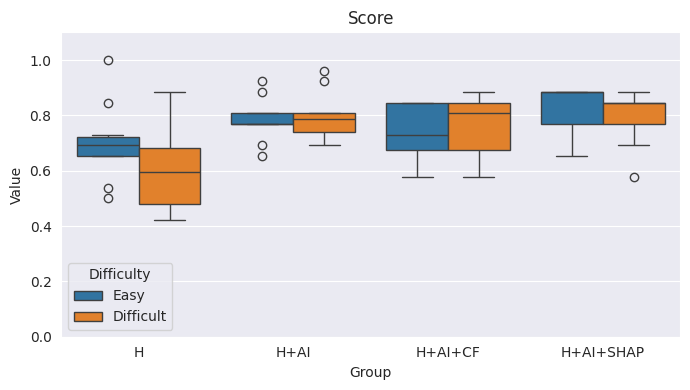

In [52]:
plot_boxplot_two(all_scores_easy, all_scores_difficult, "Group", labels=["Easy", "Difficult"], title="Score", dataset_name="Difficulty", y_lim=(0, 1.1))

In [53]:
all_reliance, all_overreliance

({'H': [0.6153846153846154,
   0.6538461538461539,
   0.5961538461538461,
   0.6538461538461539,
   0.6538461538461539,
   0.6346153846153846,
   0.7884615384615384,
   0.4807692307692308,
   0.5,
   0.6538461538461539],
  'H+AI': [0.75,
   0.8269230769230769,
   0.8269230769230769,
   0.8461538461538461,
   0.8461538461538461,
   0.6923076923076923,
   0.8269230769230769,
   0.8269230769230769,
   0.5576923076923077,
   0.8461538461538461],
  'H+AI+CF': [0.9038461538461539,
   0.7692307692307693,
   0.9423076923076923,
   0.9038461538461539,
   0.8653846153846154,
   0.9423076923076923,
   0.7115384615384616,
   0.5576923076923077,
   0.7115384615384616,
   1.0,
   0.9615384615384616],
  'H+AI+SHAP': [0.8269230769230769,
   0.9807692307692307,
   1.0,
   0.8076923076923077,
   0.75,
   0.6153846153846154,
   0.9615384615384616,
   0.8076923076923077,
   0.8846153846153846]},
 {'H': [0.375, 0.5, 0.375, 0.375, 0.125, 0.5, 0.0, 0.25, 0.5, 0.5],
  'H+AI': [0.5, 0.125, 0.625, 0.75, 0.625, 

In [54]:
all_reliance_easy, all_overreliance_easy

({'H': [0.6538461538461539,
   0.6923076923076923,
   0.6153846153846154,
   0.6153846153846154,
   0.6153846153846154,
   0.6923076923076923,
   0.8461538461538461,
   0.5,
   0.46153846153846156,
   0.7307692307692307],
  'H+AI': [0.7692307692307693,
   0.7692307692307693,
   0.7692307692307693,
   0.8461538461538461,
   0.8076923076923077,
   0.6153846153846154,
   0.7692307692307693,
   0.8076923076923077,
   0.5769230769230769,
   0.8461538461538461],
  'H+AI+CF': [0.8461538461538461,
   0.7307692307692307,
   1.0,
   0.9230769230769231,
   0.7692307692307693,
   0.9230769230769231,
   0.7307692307692307,
   0.5769230769230769,
   0.8076923076923077,
   1.0,
   1.0],
  'H+AI+SHAP': [0.8076923076923077,
   0.9615384615384616,
   1.0,
   0.7307692307692307,
   0.8076923076923077,
   0.6153846153846154,
   0.9230769230769231,
   0.8076923076923077,
   0.8846153846153846]},
 {'H': [0.5, 0.5, 0.25, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.5],
  'H+AI': [0.5, 0.0, 0.5, 0.75, 0.5, 0.25, 0.5, 0

In [55]:
all_reliance_difficult, all_overreliance_difficult

({'H': [0.5769230769230769,
   0.6153846153846154,
   0.5769230769230769,
   0.6923076923076923,
   0.6923076923076923,
   0.5769230769230769,
   0.7307692307692307,
   0.46153846153846156,
   0.5384615384615384,
   0.5769230769230769],
  'H+AI': [0.7307692307692307,
   0.8846153846153846,
   0.8846153846153846,
   0.8461538461538461,
   0.8846153846153846,
   0.7692307692307693,
   0.8846153846153846,
   0.8461538461538461,
   0.5384615384615384,
   0.8461538461538461],
  'H+AI+CF': [0.9615384615384616,
   0.8076923076923077,
   0.8846153846153846,
   0.8846153846153846,
   0.9615384615384616,
   0.9615384615384616,
   0.6923076923076923,
   0.5384615384615384,
   0.6153846153846154,
   1.0,
   0.9230769230769231],
  'H+AI+SHAP': [0.8461538461538461,
   1.0,
   1.0,
   0.8846153846153846,
   0.6923076923076923,
   0.6153846153846154,
   1.0,
   0.8076923076923077,
   0.8846153846153846]},
 {'H': [0.25, 0.5, 0.5, 0.5, 0.25, 1.0, 0.0, 0.25, 0.75, 0.5],
  'H+AI': [0.5, 0.25, 0.75, 0.75, 

In [56]:
all_reliance_mild, all_overreliance_mild

({'H': [0.6153846153846154,
   0.7307692307692307,
   0.6538461538461539,
   0.6538461538461539,
   0.7307692307692307,
   0.6538461538461539,
   0.8461538461538461,
   0.6923076923076923,
   0.5384615384615384,
   0.6923076923076923],
  'H+AI': [0.7307692307692307,
   0.8461538461538461,
   0.7692307692307693,
   0.8076923076923077,
   0.8076923076923077,
   0.6153846153846154,
   0.7692307692307693,
   0.8076923076923077,
   0.6153846153846154,
   0.8461538461538461],
  'H+AI+CF': [0.8461538461538461,
   0.6538461538461539,
   0.8846153846153846,
   0.8846153846153846,
   0.8461538461538461,
   0.9230769230769231,
   0.6923076923076923,
   0.6923076923076923,
   0.8076923076923077,
   1.0,
   0.9230769230769231],
  'H+AI+SHAP': [0.7307692307692307,
   0.9615384615384616,
   1.0,
   0.7692307692307693,
   0.7692307692307693,
   0.5769230769230769,
   0.9230769230769231,
   0.8461538461538461,
   0.8461538461538461]},
 {'H': [0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.0, 0.5, 0.75, 0.25],
  'H

In [57]:
all_reliance_strong, all_overreliance_strong

({'H': [0.6153846153846154,
   0.5769230769230769,
   0.5384615384615384,
   0.6538461538461539,
   0.5769230769230769,
   0.6153846153846154,
   0.7307692307692307,
   0.2692307692307692,
   0.46153846153846156,
   0.6153846153846154],
  'H+AI': [0.7692307692307693,
   0.8076923076923077,
   0.8846153846153846,
   0.8846153846153846,
   0.8846153846153846,
   0.7692307692307693,
   0.8846153846153846,
   0.8461538461538461,
   0.5,
   0.8461538461538461],
  'H+AI+CF': [0.9615384615384616,
   0.8846153846153846,
   1.0,
   0.9230769230769231,
   0.8846153846153846,
   0.9615384615384616,
   0.7307692307692307,
   0.4230769230769231,
   0.6153846153846154,
   1.0,
   1.0],
  'H+AI+SHAP': [0.9230769230769231,
   1.0,
   1.0,
   0.8461538461538461,
   0.7307692307692307,
   0.6538461538461539,
   1.0,
   0.7692307692307693,
   0.9230769230769231]},
 {'H': [0.25, 0.75, 0.25, 0.5, 0.0, 0.5, 0.0, 0.0, 0.25, 0.75],
  'H+AI': [0.5, 0.25, 0.75, 1.0, 0.75, 0.5, 0.75, 0.75, 0.0, 0.5],
  'H+AI+CF'

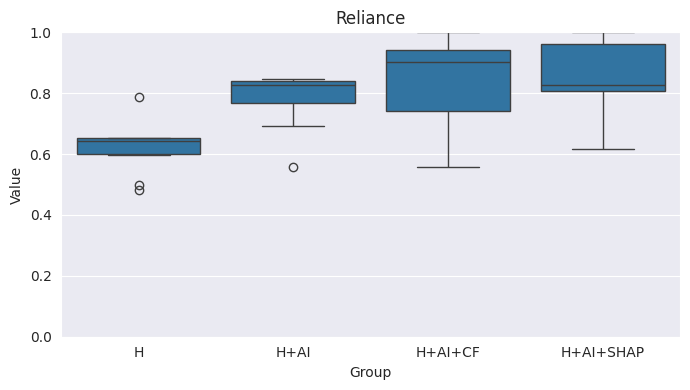

In [58]:
plot_boxplot(all_reliance, "Group", title="Reliance", y_lim=(0, 1))


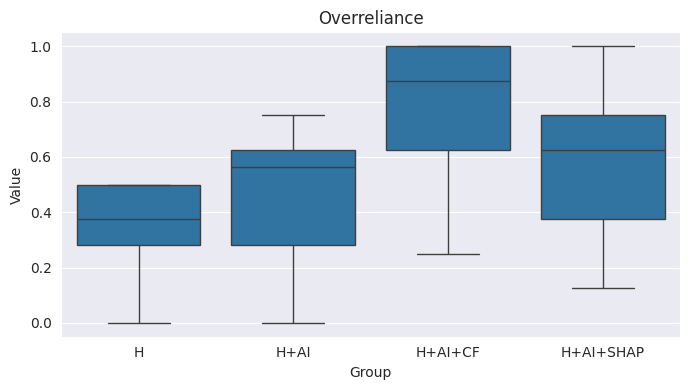

In [59]:
plot_boxplot(all_overreliance, "Group", title="Overreliance")


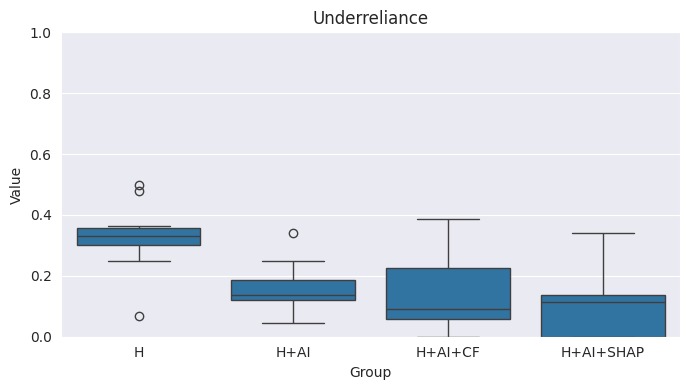

In [60]:
plot_boxplot(all_underreliance, "Group", title="Underreliance", y_lim=(0, 1))


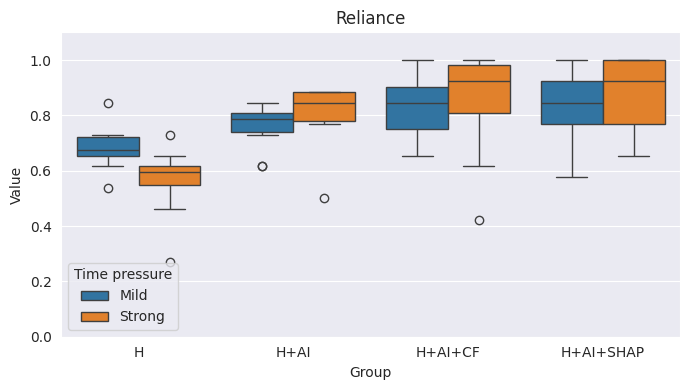

In [61]:
plot_boxplot_two(all_reliance_mild, all_reliance_strong, "Group", labels=["Mild", "Strong"], title="Reliance", dataset_name="Time pressure", y_lim=(0, 1.1))

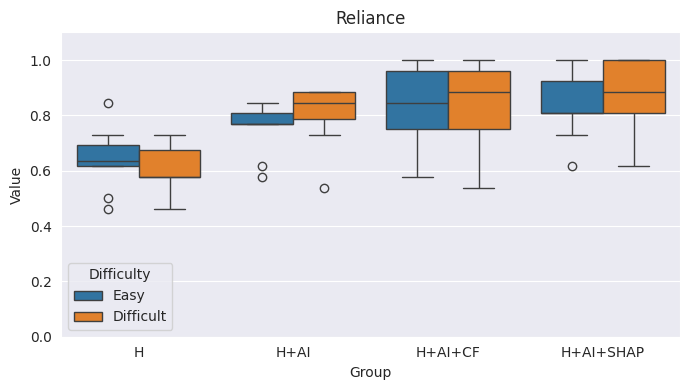

In [62]:
plot_boxplot_two(all_reliance_easy, all_reliance_difficult, "Group", labels=["Easy", "Difficult"], title="Reliance", dataset_name="Difficulty", y_lim=(0, 1.1))

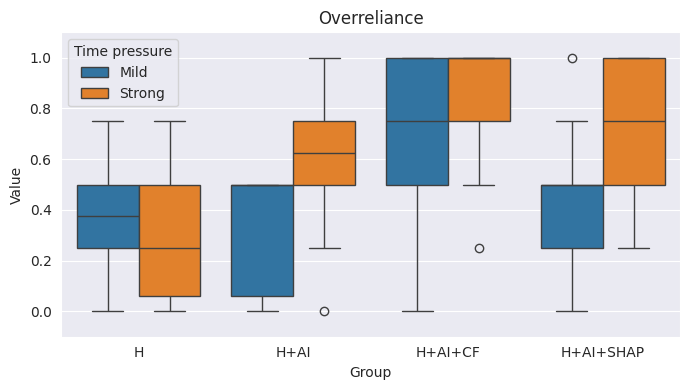

In [63]:
plot_boxplot_two(all_overreliance_mild, all_overreliance_strong, "Group", labels=["Mild", "Strong"], title="Overreliance", dataset_name="Time pressure",
                 y_lim=(-0.1, 1.1))

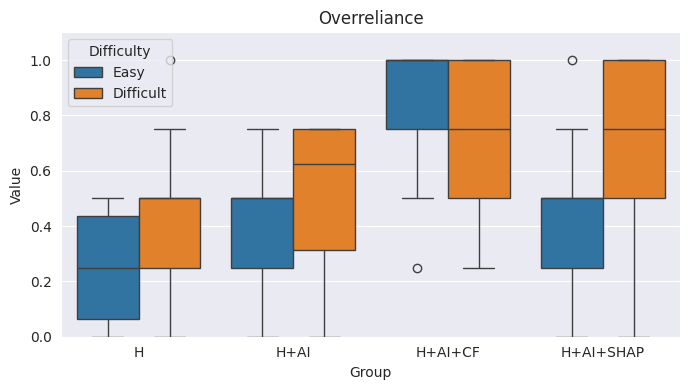

In [64]:
plot_boxplot_two(all_overreliance_easy, all_overreliance_difficult, "Group", labels=["Easy", "Difficult"], title="Overreliance", dataset_name="Difficulty", y_lim=(0, 1.1))

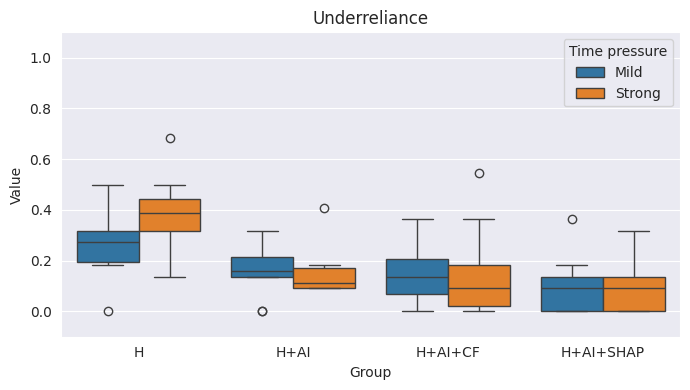

In [65]:
plot_boxplot_two(all_underreliance_mild, all_underreliance_strong, "Group", labels=["Mild", "Strong"], title="Underreliance", dataset_name="Time pressure",
                 y_lim=(-0.1, 1.1))

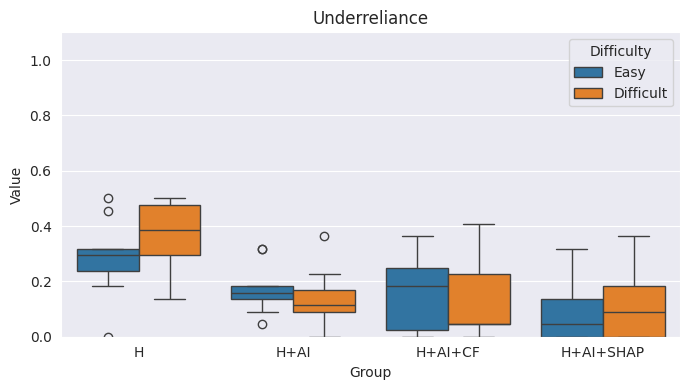

In [66]:
plot_boxplot_two(all_underreliance_easy, all_underreliance_difficult, "Group", labels=["Easy", "Difficult"], title="Underreliance", dataset_name="Difficulty", y_lim=(0, 1.1))

In [67]:
from pywebxaii.resretrieval import extract_total_times


def extract_times(results_dir, results_filenames_d):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            res_dict = load_json(curr_res_path)
            total_time, _ = extract_total_times(res_dict)

            output_res_d[group_key].append(total_time / 60)

    return output_res_d


In [68]:
times_data = extract_times(results_dir, results_filenames_d)

In [69]:
times_data

{'H': [21.21685,
  30.1071,
  25.08905,
  23.419966666666667,
  20.72713333333333,
  26.91815,
  20.656066666666668,
  33.19863333333333,
  18.21193333333333,
  21.480366666666665],
 'H+AI': [17.7659,
  17.051666666666666,
  35.35615,
  22.415266666666664,
  17.518916666666666,
  28.60663333333333,
  19.661483333333333,
  16.377,
  28.131933333333333,
  19.515083333333333],
 'H+AI+CF': [22.17885,
  21.9907,
  15.221816666666665,
  33.17175,
  19.304633333333335,
  18.68951666666667,
  24.110200000000003,
  35.56198333333334,
  26.657866666666667,
  16.341216666666664,
  17.6719],
 'H+AI+SHAP': [19.223133333333333,
  17.070316666666667,
  19.408566666666665,
  25.5201,
  19.97025,
  20.213266666666666,
  15.477633333333333,
  22.057066666666667,
  47.48396666666667]}

In [70]:
alltimes = []
for k, v in times_data.items():
    alltimes.extend(v)
print({f"median : {np.median(alltimes)}"})

{'median : 20.971991666666668'}


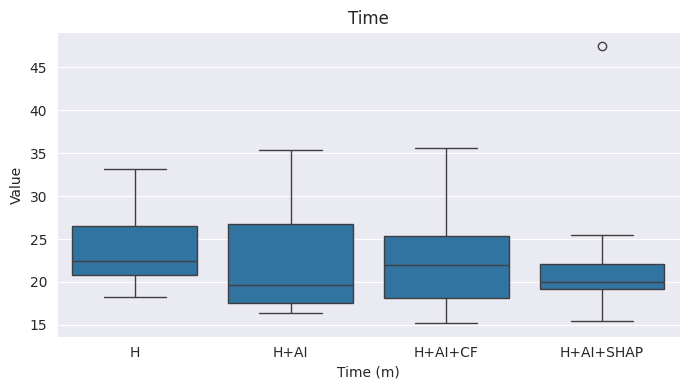

In [71]:
plot_boxplot(times_data, "Time (m)", title="Time")


In [73]:
def process_cogload(cogload_results):
    output_d = {}
    for k, v in cogload_results.items():
        output_d[k] = {}
        for session_id, results_list in v["raw"].items():

            if session_id == "mainexp_easy_mild_cogload":
                session_name = "easy;mild"
            elif session_id == "mainexp_easy_strong_cogload":
                session_name = "easy;strong"
            elif session_id == "mainexp_hard_mild_cogload":
                session_name = "hard;mild"
            elif session_id == "mainexp_hard_strong_cogload":
                session_name = "hard;strong"

            if session_id not in output_d:
                output_d[k][session_name] = []
            for result_arr in results_list:
                output_d[k][session_name].append(np.sum(result_arr))

    return output_d


In [74]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [75]:
# cogload_results

In [76]:
cogload_processed = process_cogload(cogload_results)

In [77]:
cogload_processed

{'H': {'easy;mild': [24, 23, 18, 18, 26, 27, 20, 20, 24, 20],
  'easy;strong': [29, 30, 19, 27, 28, 29, 23, 24, 28, 30],
  'hard;mild': [28, 29, 19, 21, 27, 31, 21, 11, 26, 29],
  'hard;strong': [30, 33, 24, 31, 34, 28, 27, 21, 27, 30]},
 'H+AI': {'easy;mild': [20, 11, 17, 29, 22, 28, 12, 20, 26, 12],
  'easy;strong': [22, 15, 25, 30, 25, 30, 24, 23, 25, 18],
  'hard;mild': [17, 9, 23, 26, 15, 29, 17, 21, 25, 19],
  'hard;strong': [21, 12, 26, 33, 18, 30, 27, 20, 27, 11]},
 'H+AI+CF': {'easy;mild': [22, 22, 5, 10, 24, 10, 24, 27, 21, 19, 13],
  'easy;strong': [9, 23, 5, 20, 26, 7, 29, 34, 18, 15, 17],
  'hard;mild': [23, 19, 26, 15, 26, 6, 22, 31, 10, 20, 17],
  'hard;strong': [9, 25, 3, 20, 27, 6, 18, 35, 28, 17, 22]},
 'H+AI+SHAP': {'easy;mild': [24, 17, 18, 22, 12, 25, 18, 13, 27],
  'easy;strong': [27, 4, 12, 21, 12, 28, 7, 22, 30],
  'hard;mild': [28, 7, 12, 20, 9, 35, 13, 21, 30],
  'hard;strong': [31, 7, 16, 21, 14, 36, 10, 25, 35]}}

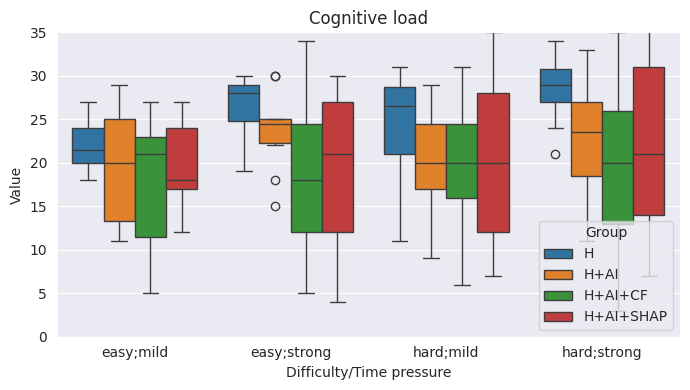

In [78]:
plot_boxplot_nested(
    cogload_processed,
    "Difficulty/Time pressure",
    dataset_name="Group",
    title="Cognitive load",
    y_lim=(0,35),
    y_line=None,
    figsize=(7, 4),
)

In [79]:
plot_grouped_histograms(cogload_processed, xlim=(0, 35), ylim=(0, 7), figsize=(12, 6), bins=np.arange(0, 35, 4))


NameError: name 'plot_grouped_histograms' is not defined

In [80]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [81]:
# cogload_results

In [82]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1"])


{'H': {'raw': {'attentioncheck_1': [array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disag

In [83]:

extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_2"])


{'H': {'raw': {}, 'values': {}, 'times': {}},
 'H+AI': {'raw': {}, 'values': {}, 'times': {}},
 'H+AI+CF': {'raw': {'attentioncheck_2': [array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object)]},
  'values': {'attentioncheck_2': [array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',

In [84]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck2"])


{'H': {'raw': {'attentioncheck2': [array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object)]},
  'values': {'attentioncheck2': [array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching

In [85]:
def process_reliance_list_data(reliance_data_list):

    output_reliance = None
    output_trust = None
    output_xai_reliance = None

    if len(reliance_data_list) > 0:
        output_reliance = reliance_data_list[0]
    if len(reliance_data_list) > 1:
        output_trust = reliance_data_list[1]
    if len(reliance_data_list) > 2:
        output_xai_reliance = reliance_data_list[2]

    return output_reliance, output_trust, output_xai_reliance

def extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d):

    output_d = {}

    form_keys = ["mainexp_easy_mild_reliance",
            "mainexp_easy_strong_reliance",
            "mainexp_hard_mild_reliance",
            "mainexp_hard_strong_reliance"]

    data = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, form_keys)

    for key_group, data in data.items():
        output_d[key_group] = {}

        for form_key in form_keys:
            output_d[key_group][form_key] = {
                "reliance": [],
                "trust": [],
                "xai_reliance": [],
            }

            if form_key not in data["raw"]:
                continue

            for arr in data["raw"][form_key]:
                reliance, trust, xai_reliance = process_reliance_list_data(arr)
                if reliance is not None:
                    output_d[key_group][form_key]["reliance"].append(reliance)

                if trust is not None:
                    output_d[key_group][form_key]["trust"].append(trust)

                if xai_reliance is not None:
                    output_d[key_group][form_key]["xai_reliance"].append(xai_reliance)

    return output_d


In [86]:
processed_reliance_data = extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d)


In [87]:
processed_reliance_data

{'H': {'mainexp_easy_mild_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_easy_strong_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_hard_mild_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_hard_strong_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []}},
 'H+AI': {'mainexp_easy_mild_reliance': {'reliance': [4,
    0,
    2,
    4,
    2,
    2,
    4,
    0,
    0,
    1],
   'trust': [4, 3, 1, 4, 4, 0, 4, 3, 2, 1],
   'xai_reliance': []},
  'mainexp_easy_strong_reliance': {'reliance': [5, 0, 4, 6, 4, 5, 4, 0, 0, 1],
   'trust': [4, 3, 3, 6, 2, 2, 4, 3, 2, 1],
   'xai_reliance': []},
  'mainexp_hard_mild_reliance': {'reliance': [4, 0, 4, 5, 1, 5, 1, 1, 0, 4],
   'trust': [4, 3, 4, 5, 1, 2, 1, 3, 2, 4],
   'xai_reliance': []},
  'mainexp_hard_strong_reliance': {'reliance': [5, 1, 4, 6, 6, 5, 6, 6, 0, 6],
   'trust': [4, 3, 4, 6, 4, 2, 6, 3, 2, 6],
   'xai_reliance': []}},
 'H+A

In [88]:
def get_data_for_reliance_plots(processed_reliance_data, target_key):

    output_d = {k: {} for k in results_filenames_d.keys()}

    for group_key, group_data in processed_reliance_data.items():
        for form_key, form_data in group_data.items():
            output_d[group_key][form_key] = form_data[target_key]

    return output_d

def plot_grouped_histograms(data, xlim, ylim=None, alpha=0.5, figsize=(12, 6), bins=None):
    """
    Plots histograms for nested group data.

    Parameters:
        data (dict):
            {
                "group1": {"groupA": [...], "groupB": [...], ...},
                "group2": {"groupA": [...], "groupB": [...], ...},
                ...
            }
        bins (int): Number of bins for histograms.
        alpha (float): Transparency for the overlapping histograms.
        figsize (tuple): Figure size.
    """

    # Get all subgroup names (e.g., groupA, groupB...)
    subgroups = sorted({sg for g in data.values() for sg in g.keys()})

    # Create one subplot per subgroup
    fig, axes = plt.subplots(1, len(subgroups), figsize=figsize, squeeze=False)
    axes = axes[0]

    # Prepare colors (matplotlib will cycle them automatically)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {gname: colors[i % len(colors)] for i, gname in enumerate(data.keys())}

    for ax, subgroup in zip(axes, subgroups):
        for group_name, group_dict in data.items():
            if subgroup in group_dict:
                values = group_dict[subgroup]
                if values:  # skip empty lists
                    ax.hist(values, alpha=alpha,
                            label=group_name, color=color_map[group_name], bins=bins)

        ax.set_title(subgroup)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [89]:
declared_reliance_plot_data = get_data_for_reliance_plots(processed_reliance_data, "reliance")
declared_trust_plot_data = get_data_for_reliance_plots(processed_reliance_data, "trust")
declared_xai_reliance_plot_data = get_data_for_reliance_plots(processed_reliance_data, "xai_reliance")

In [90]:
declared_reliance_plot_data

{'H': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []},
 'H+AI': {'mainexp_easy_mild_reliance': [4, 0, 2, 4, 2, 2, 4, 0, 0, 1],
  'mainexp_easy_strong_reliance': [5, 0, 4, 6, 4, 5, 4, 0, 0, 1],
  'mainexp_hard_mild_reliance': [4, 0, 4, 5, 1, 5, 1, 1, 0, 4],
  'mainexp_hard_strong_reliance': [5, 1, 4, 6, 6, 5, 6, 6, 0, 6]},
 'H+AI+CF': {'mainexp_easy_mild_reliance': [2, 0, 6, 0, 3, 6, 5, 0, 6, 5, 5],
  'mainexp_easy_strong_reliance': [6, 4, 6, 2, 5, 6, 6, 3, 4, 6, 6],
  'mainexp_hard_mild_reliance': [0, 4, 5, 0, 4, 6, 5, 0, 1, 5, 5],
  'mainexp_hard_strong_reliance': [6, 6, 6, 6, 5, 6, 4, 3, 6, 6, 6]},
 'H+AI+SHAP': {'mainexp_easy_mild_reliance': [2, 5, 4, 2, 0, 1, 1, 4, 4],
  'mainexp_easy_strong_reliance': [4, 6, 6, 6, 3, 0, 6, 4, 4],
  'mainexp_hard_mild_reliance': [2, 6, 5, 4, 0, 4, 6, 4, 5],
  'mainexp_hard_strong_reliance': [4, 6, 6, 4, 1, 5, 6, 5, 6]}}

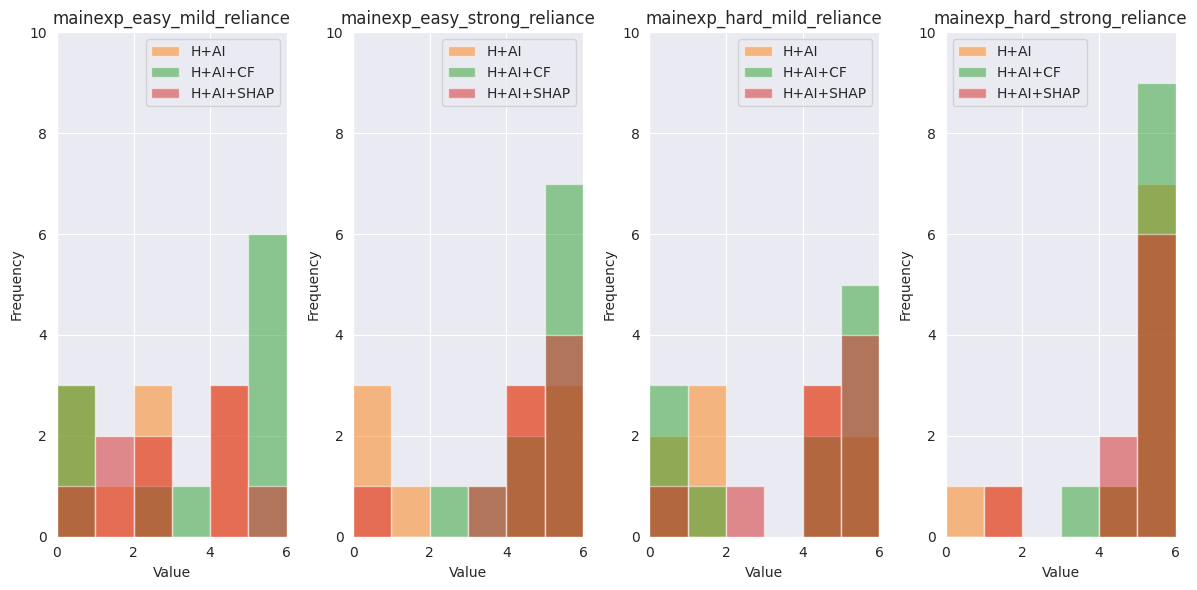

In [91]:
plot_grouped_histograms(declared_reliance_plot_data, xlim=(0, 6), ylim=(0, 10), figsize=(12, 6), bins=np.arange(7))


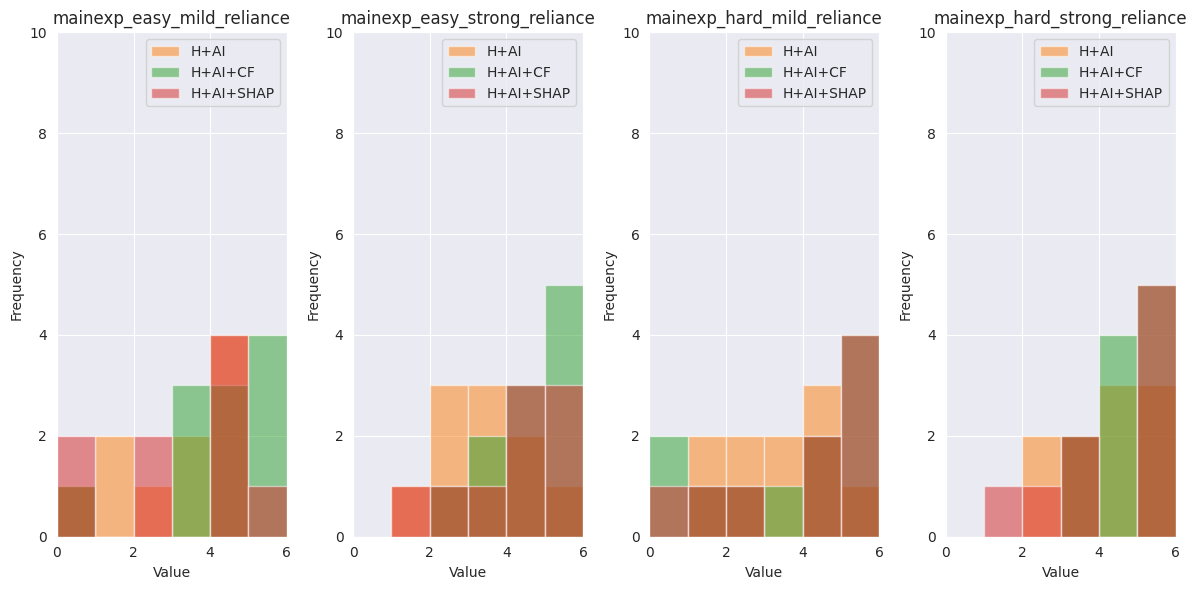

In [92]:
plot_grouped_histograms(declared_trust_plot_data, xlim=(0, 6), ylim=(0, 10), figsize=(12, 6), bins=np.arange(7))


In [93]:
declared_xai_reliance_plot_data

{'H': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []},
 'H+AI': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []},
 'H+AI+CF': {'mainexp_easy_mild_reliance': [5, 3, 0, 0, 4, 6, 6, 1, 6, 4, 5],
  'mainexp_easy_strong_reliance': [6, 4, 0, 0, 5, 6, 5, 0, 3, 4, 6],
  'mainexp_hard_mild_reliance': [3, 4, 1, 0, 4, 6, 5, 0, 6, 3, 6],
  'mainexp_hard_strong_reliance': [3, 4, 0, 0, 4, 6, 5, 3, 2, 5, 6]},
 'H+AI+SHAP': {'mainexp_easy_mild_reliance': [4, 4, 6, 3, 0, 0, 4, 5, 4],
  'mainexp_easy_strong_reliance': [4, 6, 5, 6, 3, 1, 2, 5, 4],
  'mainexp_hard_mild_reliance': [4, 4, 6, 6, 0, 2, 1, 5, 5],
  'mainexp_hard_strong_reliance': [3, 3, 6, 6, 1, 1, 3, 5, 6]}}

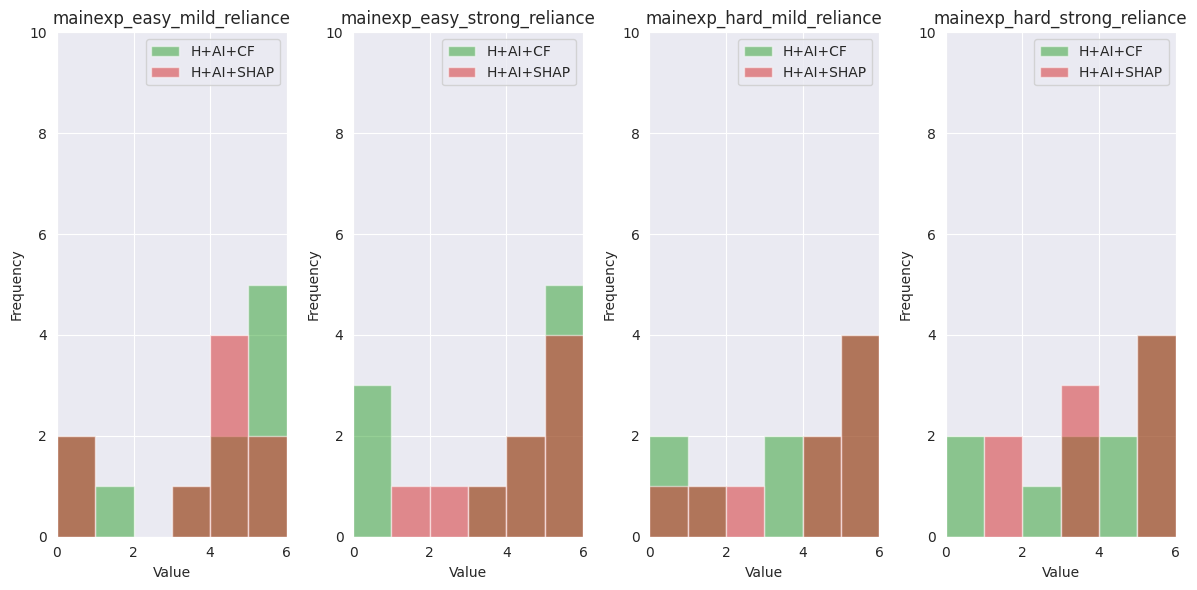

In [94]:
plot_grouped_histograms(declared_xai_reliance_plot_data, xlim=(0, 6), ylim=(0, 10), figsize=(12, 6), bins=np.arange(7))


In [95]:
all_reliance_strong

{'H': [0.6153846153846154,
  0.5769230769230769,
  0.5384615384615384,
  0.6538461538461539,
  0.5769230769230769,
  0.6153846153846154,
  0.7307692307692307,
  0.2692307692307692,
  0.46153846153846156,
  0.6153846153846154],
 'H+AI': [0.7692307692307693,
  0.8076923076923077,
  0.8846153846153846,
  0.8846153846153846,
  0.8846153846153846,
  0.7692307692307693,
  0.8846153846153846,
  0.8461538461538461,
  0.5,
  0.8461538461538461],
 'H+AI+CF': [0.9615384615384616,
  0.8846153846153846,
  1.0,
  0.9230769230769231,
  0.8846153846153846,
  0.9615384615384616,
  0.7307692307692307,
  0.4230769230769231,
  0.6153846153846154,
  1.0,
  1.0],
 'H+AI+SHAP': [0.9230769230769231,
  1.0,
  1.0,
  0.8461538461538461,
  0.7307692307692307,
  0.6538461538461539,
  1.0,
  0.7692307692307693,
  0.9230769230769231]}

In [96]:
MILD_PRESSURE_TASKS = ["med1_find_pattern_rot", "hard1_find_pattern_rot"]
STRONG_PRESSURE_TASKS = ["med3_find_pattern_rot", "hard3_find_pattern_rot"]

In [97]:
_, reliance_easy_mild, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["med1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
_, reliance_easy_strong, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["med3_find_pattern_rot"], TASK_PROTOCOL_KEYS)
_, reliance_hard_mild, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
_, reliance_hard_strong, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard3_find_pattern_rot"], TASK_PROTOCOL_KEYS)


ValueError: too many values to unpack (expected 4)

In [98]:
processed_reliance_data

{'H': {'mainexp_easy_mild_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_easy_strong_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_hard_mild_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_hard_strong_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []}},
 'H+AI': {'mainexp_easy_mild_reliance': {'reliance': [4,
    0,
    2,
    4,
    2,
    2,
    4,
    0,
    0,
    1],
   'trust': [4, 3, 1, 4, 4, 0, 4, 3, 2, 1],
   'xai_reliance': []},
  'mainexp_easy_strong_reliance': {'reliance': [5, 0, 4, 6, 4, 5, 4, 0, 0, 1],
   'trust': [4, 3, 3, 6, 2, 2, 4, 3, 2, 1],
   'xai_reliance': []},
  'mainexp_hard_mild_reliance': {'reliance': [4, 0, 4, 5, 1, 5, 1, 1, 0, 4],
   'trust': [4, 3, 4, 5, 1, 2, 1, 3, 2, 4],
   'xai_reliance': []},
  'mainexp_hard_strong_reliance': {'reliance': [5, 1, 4, 6, 6, 5, 6, 6, 0, 6],
   'trust': [4, 3, 4, 6, 4, 2, 6, 3, 2, 6],
   'xai_reliance': []}},
 'H+A

In [99]:
all_times_easy

{'H': [11.3,
  9.8,
  12.2,
  10.3,
  8.7,
  8.7,
  7.4,
  10.6,
  6.6,
  9.3,
  13.2,
  12.6,
  13.1,
  8.0,
  4.2,
  6.7,
  8.2,
  8.1,
  3.6,
  8.5,
  6.6,
  6.6,
  4.1,
  5.2,
  5.0,
  10.0,
  16.4,
  12.1,
  17.8,
  17.6,
  18.9,
  12.4,
  17.7,
  16.5,
  11.7,
  13.7,
  6.7,
  18.3,
  8.8,
  8.2,
  3.9,
  9.5,
  10.0,
  9.7,
  9.2,
  7.1,
  7.7,
  8.2,
  8.2,
  4.7,
  8.9,
  9.2,
  18.5,
  6.8,
  19.1,
  16.2,
  18.2,
  9.7,
  7.5,
  13.5,
  16.1,
  18.1,
  17.4,
  17.6,
  7.8,
  8.3,
  4.8,
  8.7,
  9.6,
  6.4,
  8.6,
  7.2,
  7.4,
  8.5,
  7.1,
  8.1,
  10.0,
  8.0,
  14.4,
  14.8,
  17.3,
  15.8,
  16.6,
  16.9,
  16.8,
  15.8,
  8.5,
  7.7,
  16.9,
  15.5,
  12.7,
  8.9,
  8.4,
  10.0,
  10.0,
  10.0,
  6.2,
  9.3,
  9.3,
  9.1,
  8.2,
  7.0,
  8.4,
  8.9,
  15.5,
  17.5,
  13.5,
  14.0,
  18.1,
  8.9,
  11.6,
  11.3,
  13.3,
  11.2,
  9.0,
  20.0,
  11.2,
  6.8,
  10.0,
  9.9,
  7.4,
  10.0,
  6.0,
  6.7,
  5.9,
  6.9,
  10.0,
  6.2,
  7.9,
  4.0,
  16.7,
  16.0,
  16.7,
  1

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_histogram_with_density(data_dict, title="Histogram with Density", xlabel="Value", ylabel="Density"):
    """
    Plots a histogram with density (KDE) for each group in the data dictionary.

    Parameters:
    - data_dict: Dictionary of the form {"group1": [values], "group2": [values], ...}
    - title: Title of the plot
    - xlabel: Label for the x-axis
    - ylabel: Label for the y-axis
    """
    # Convert the dictionary to a DataFrame for easier plotting
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

    # Melt the DataFrame for seaborn
    df_melted = df.melt(var_name='groups', value_name='values')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_melted, x='values', hue='groups', kde=True, element='step', stat='density', common_norm=False)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



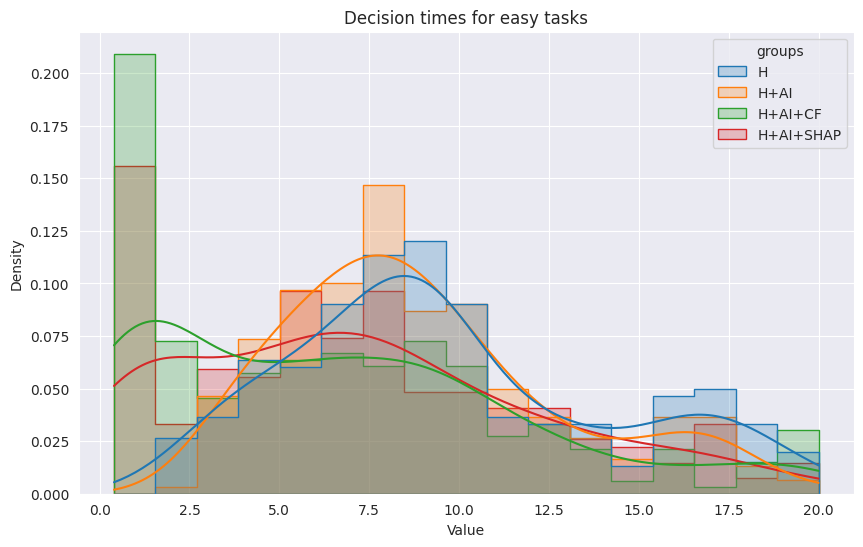

In [102]:
plot_histogram_with_density(all_times_mild, title="Decision times for easy tasks")

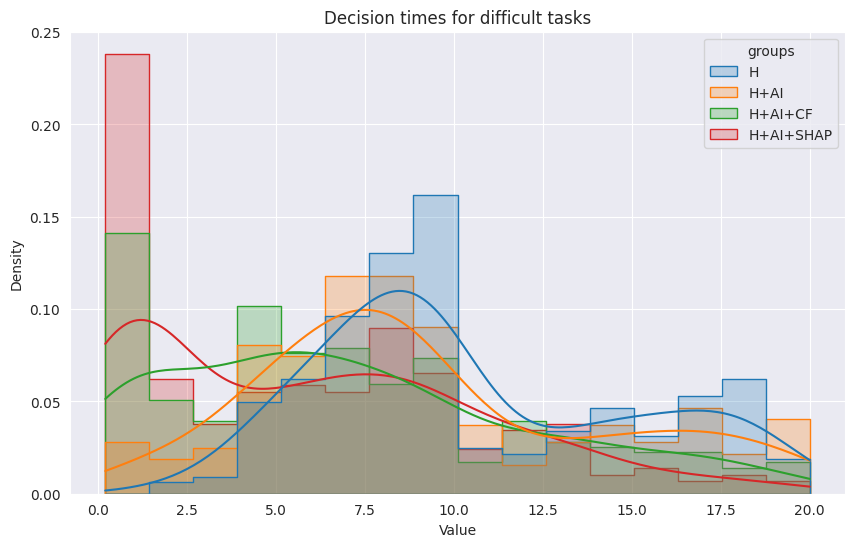

In [103]:
plot_histogram_with_density(all_times_difficult, title="Decision times for difficult tasks")

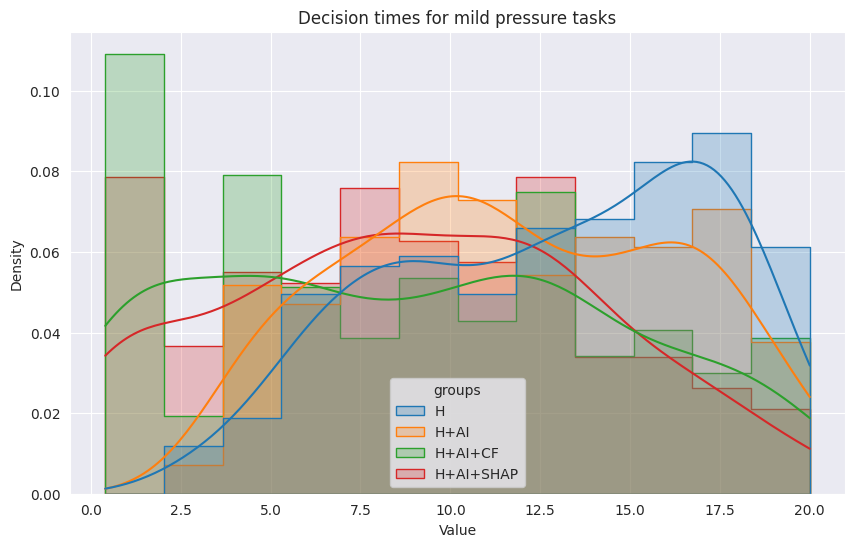

In [104]:
plot_histogram_with_density(all_times_mild, title="Decision times for mild pressure tasks")

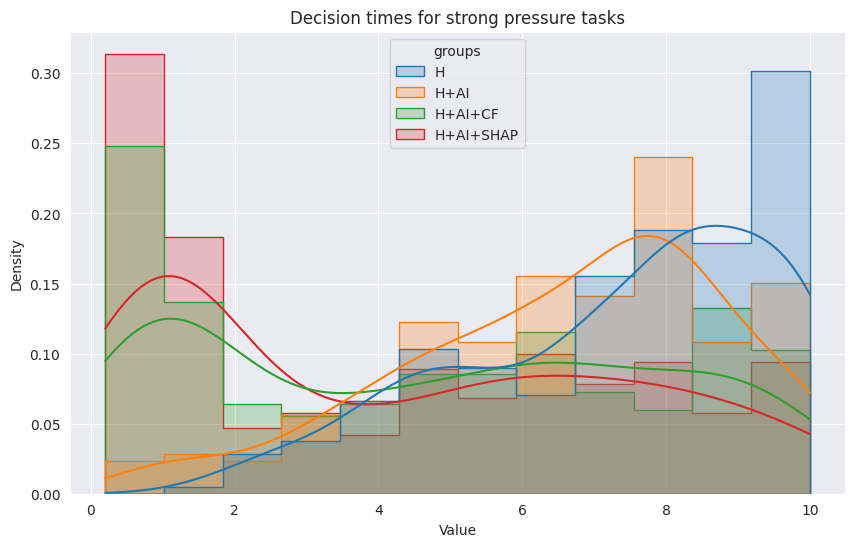

In [105]:
plot_histogram_with_density(all_times_strong, title="Decision times for strong pressure tasks")

In [106]:
N_per_group = 50

In [125]:
reliance_easy_mild["H+AI+SHAP"] = np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_easy_strong["H+AI+SHAP"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()
reliance_hard_mild["H+AI+SHAP"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()
reliance_hard_strong["H+AI+SHAP"] =  np.random.normal(0.9, 0.1, N_per_group).tolist()

reliance_easy_mild["H+AI+CF"] = np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_easy_strong["H+AI+CF"] =  np.random.normal(0.65, 0.1, N_per_group).tolist()
reliance_hard_mild["H+AI+CF"] =  np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_hard_strong["H+AI+CF"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()

reliance_easy_mild["H"] = np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_easy_strong["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_hard_mild["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_hard_strong["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()


In [126]:
reliance_easy_mild

{'H': [0.6357198888844691,
  0.33557963513821537,
  0.46368393401356167,
  0.4211374731321458,
  0.6568213474649885,
  0.5126141593359248,
  0.5322354306128207,
  0.6939092013292222,
  0.43713138900518894,
  0.5007061312474176,
  0.5230088580291855,
  0.36738089379805494,
  0.6064221020831737,
  0.5431193037133322,
  0.4384178813963483,
  0.42099446980551214,
  0.4867960621568033,
  0.47829049701093385,
  0.35421668569912934,
  0.4613944967615717,
  0.5520932392981281,
  0.511357527513437,
  0.490254435864462,
  0.43360423714790014,
  0.4388745232498348,
  0.6503368542773302,
  0.5611034321621811,
  0.4952169130497481,
  0.5047173595348792,
  0.5292583375635104,
  0.46262404086812253,
  0.5696256756564148,
  0.6398957788838769,
  0.5664370493411272,
  0.5142280758453915,
  0.3236823684513841,
  0.5654512785984044,
  0.5517384548033356,
  0.39307703454067056,
  0.35883195947981206,
  0.4365379682332651,
  0.40276065435282543,
  0.42648293539385634,
  0.35923831389630334,
  0.52009653908

In [127]:
def create_df():
    data_participants = []
    data_difficulty = []
    data_pressure = []
    data_reliance = []
    data_xai_condition = []
    # data_trust = []

    for xai_condition in ["H+AI+SHAP", "H+AI+CF", "H"]:

        data_reliance.extend(reliance_easy_mild[xai_condition])
        # data_trust.extend(processed_reliance_data[xai_condition]["mainexp_easy_mild_reliance"]["trust"])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["mild" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_easy_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_mild[xai_condition]))])

        data_reliance.extend(reliance_easy_strong[xai_condition])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_strong[xai_condition]))])
        # data_trust.extend(processed_reliance_data[xai_condition]["mainexp_easy_strong_reliance"]["trust"])
        data_pressure.extend(["strong" for k in range(len(reliance_easy_strong[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_easy_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_strong[xai_condition]))])

        data_reliance.extend(reliance_hard_mild[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_mild[xai_condition]))])
        # data_trust.extend(processed_reliance_data[xai_condition]["mainexp_hard_mild_reliance"]["trust"])
        data_pressure.extend(["mild" for k in range(len(reliance_hard_mild[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_hard_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_mild[xai_condition]))])

        data_reliance.extend(reliance_hard_strong[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_strong[xai_condition]))])
        # data_trust.extend(processed_reliance_data[xai_condition]["mainexp_hard_strong_reliance"]["trust"])
        data_pressure.extend(["strong" for k in range(len(reliance_hard_strong[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_hard_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_strong[xai_condition]))])

    print(len(data_participants))
    print(len(data_difficulty))
    print(len(data_pressure))
    print(len(data_reliance))
    # print(len(data_trust))
    print(len(data_xai_condition))
    return pd.DataFrame({
        "participant": data_participants,
        "difficulty": data_difficulty,
        "pressure": data_pressure,
        "reliance": data_reliance,
        # "trust": data_trust,
        "xai_condition": data_xai_condition
    })


In [128]:
df = create_df()
# df["participant"] = df["participant"].astype("category")
df["pressure"] = df["pressure"].astype("category")
df["difficulty"] = df["difficulty"].astype("category")
df["xai_condition"] = df["xai_condition"].astype("category")

df["pressure"] = pd.Categorical(
    df["pressure"],
    categories=["mild", "strong"],
    ordered=True
)

df["difficulty"] = pd.Categorical(
    df["difficulty"],
    categories=["easy", "hard"],
    ordered=True
)

df["xai_condition"] = pd.Categorical(
    df["xai_condition"],
    categories=["H", "H+AI+CF", "H+AI+SHAP"],
    ordered=False
)


600
600
600
600
600


In [129]:
import pandas as pd

data = pd.DataFrame({
    "participant": [1, 1, 1, 1, 2, 2, 2, 2],
    "difficulty": ["easy", "hard", "easy", "hard", "easy", "hard", "easy", "hard"],
    "pressure": ["low", "low", "strong", "strong", "low", "low", "strong", "strong"],
    "reliance": [0.42, 0.55, 0.61, 0.70, 0.38, 0.50, 0.60, 0.68]
})


In [130]:
# df = data

In [131]:
df

,participant,difficulty,pressure,reliance,xai_condition
0,1,easy,mild,0.679649,H+AI+SHAP
1,2,easy,mild,0.555815,H+AI+SHAP
2,3,easy,mild,0.628685,H+AI+SHAP
3,4,easy,mild,0.561639,H+AI+SHAP
4,5,easy,mild,0.595779,H+AI+SHAP
...,...,...,...,...,...
595,46,hard,strong,0.396202,H
596,47,hard,strong,0.633713,H
597,48,hard,strong,0.547385,H
598,49,hard,strong,0.459878,H


In [132]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "reliance ~ pressure * difficulty * xai_condition",
    df,
    groups=df["participant"]
)

result = model.fit()
print(result.summary())

                                   Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  reliance
No. Observations:                    600                      Method:                              REML    
No. Groups:                          50                       Scale:                               0.0098  
Min. group size:                     12                       Log-Likelihood:                      493.3138
Max. group size:                     12                       Converged:                           Yes     
Mean group size:                     12.0                                                                  
-----------------------------------------------------------------------------------------------------------
                                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [93]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "trust ~ pressure * difficulty * xai_condition",
    df,
    groups=df["participant"]
)

result = model.fit(method="lbfgs")
print(result.summary())

PatsyError: Error evaluating factor: NameError: name 'trust' is not defined
    trust ~ pressure * difficulty * xai_condition
    ^^^^^

In [94]:
for c in df["xai_condition"].unique():
    sub = df[df["xai_condition"] == c]
    model = smf.mixedlm(
        "reliance ~ pressure * difficulty",
        sub,
        groups=sub["participant"]
    )
    print(c)
    print(model.fit(method="lbfgs").summary())

H+AI+SHAP


/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


LinAlgError: Singular matrix

In [148]:
all_reliance_mild['H+AI+SHAP']

[0.7307692307692307,
 0.9615384615384616,
 1.0,
 0.7692307692307693,
 0.7692307692307693,
 0.5769230769230769,
 0.9230769230769231,
 0.8461538461538461,
 0.8461538461538461]

In [60]:
all_reliance_strong['H+AI+SHAP']

[0.9230769230769231,
 1.0,
 1.0,
 0.8461538461538461,
 0.7307692307692307,
 0.6538461538461539,
 1.0,
 0.7692307692307693,
 0.9230769230769231]

In [97]:
pd.crosstab(data["participant"], [data["pressure"], data["difficulty"]])

pressure     low      strong     
difficulty  easy hard   easy hard
participant                      
1              1    1      1    1
2              1    1      1    1

In [94]:
df

,participant,difficulty,pressure,reliance
0,1,easy,low,0.692308
1,2,easy,low,0.923077
2,3,easy,low,1.000000
3,4,easy,low,0.692308
4,5,easy,low,0.846154
5,6,easy,low,0.538462
6,7,easy,low,0.846154
7,8,easy,low,0.846154
8,9,easy,low,0.846154
9,1,easy,strong,0.923077
